In [13]:
import pandas as pd
import numpy as np 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [14]:
df_data = pd.read_csv("CrudeOil.csv")

Y	World Crude Oil Production
X1	U.S. Energy Consumption
X2	U.S. Nuclear Generation
X3	U.S. Coal Production
X4	U.S. Dry Gas Production
X5 	U.S. Fuel Rate for Autos


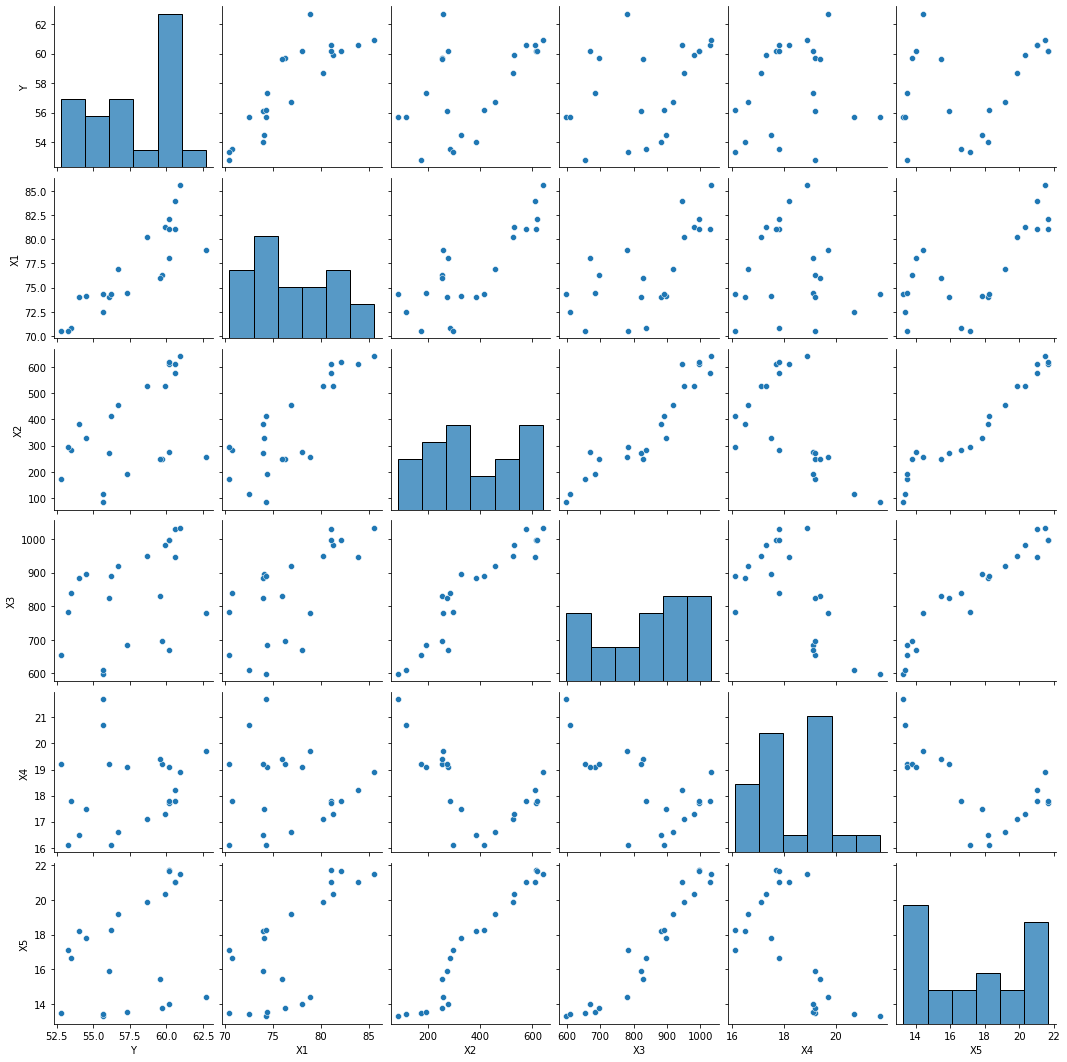

In [15]:
sns.pairplot(df_data)

In [16]:
df_data.corr(method = "pearson")

,Y,X1,X2,X3,X4,X5
Y,1.000000,0.861862,0.508893,0.390057,0.167691,0.343921
X1,0.861862,1.000000,0.808575,0.675801,-0.061540,0.693866
X2,0.508893,0.808575,1.000000,0.937456,-0.572352,0.968853
X3,0.390057,0.675801,0.937456,1.000000,-0.637790,0.959980
X4,0.167691,-0.061540,-0.572352,-0.637790,1.000000,-0.630681
X5,0.343921,0.693866,0.968853,0.959980,-0.630681,1.000000


In [17]:
df_data.corr(method = "spearman")

,Y,X1,X2,X3,X4,X5
Y,1.000000,0.916195,0.501698,0.486992,0.165060,0.473417
X1,0.916195,1.000000,0.695874,0.681176,-0.055556,0.669305
X2,0.501698,0.695874,1.000000,0.953698,-0.639300,0.987578
X3,0.486992,0.681176,0.953698,1.000000,-0.578145,0.966121
X4,0.165060,-0.055556,-0.639300,-0.578145,1.000000,-0.637602
X5,0.473417,0.669305,0.987578,0.966121,-0.637602,1.000000


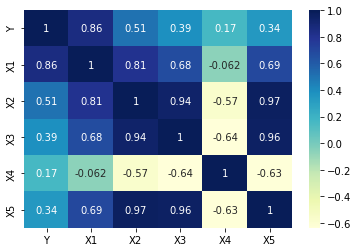

In [18]:
dataplot = sns.heatmap(df_data.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [19]:
model = smf.ols(formula="Y ~ X1 +X2+X3+X4+X5", data=df_data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     29.82
Date:                Fri, 11 Mar 2022   Prob (F-statistic):           1.44e-07
Time:                        16:52:33   Log-Likelihood:                -28.855
No. Observations:                  22   AIC:                             69.71
Df Residuals:                      16   BIC:                             76.26
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.6752     12.133      0.550      0.5

In [20]:
results.ssr

17.74909983914955

In [21]:
anova_table = sm.stats.anova_lm(results, typ=2)
print(anova_table)

             sum_sq    df          F    PR(>F)
X1        20.083058   1.0  18.103956  0.000605
X2         0.008779   1.0   0.007914  0.930216
X3         4.027186   1.0   3.630323  0.074868
X4         0.535799   1.0   0.482998  0.497037
X5         6.561677   1.0   5.915051  0.027127
Residual  17.749100  16.0        NaN       NaN


Text(0, 0.5, 'Residuals')

Text(0.5, 0, 'Fitted Values')

Text(0.5, 1.0, 'Residuals vs. Fitted')

Text(62.76888402704206, -1.8688840270420641, '21')

Text(58.54314233284894, 1.6568576671510655, '18')

Text(55.268339464731355, -1.2683394647313548, '12')

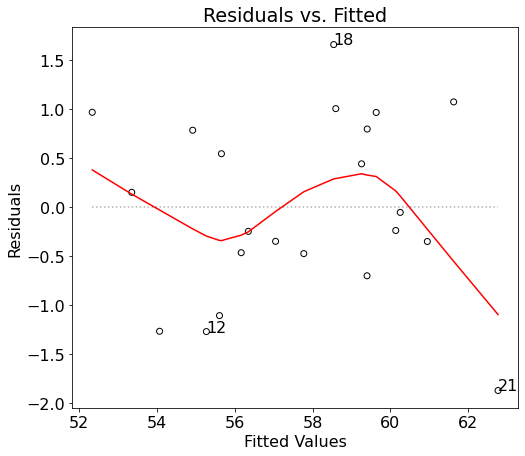

In [22]:
residuals = results.resid
fitted = results.fittedvalues
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

plt.show()

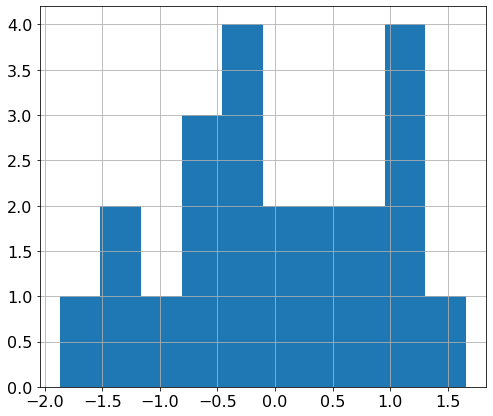

In [23]:
residuals.hist()

Text(0.5, 1.0, 'Normal Q-Q')

Text(0, 0.5, 'Standardized Residuals')

Text(0.5, 0, 'Theoretical Quantiles')

Text(-1.866073719864905, -2.1113411471576597, '21')

Text(1.866073719864905, 1.7907007395657637, '18')

Text(-1.4379145338982962, -1.5668192695422976, '2')

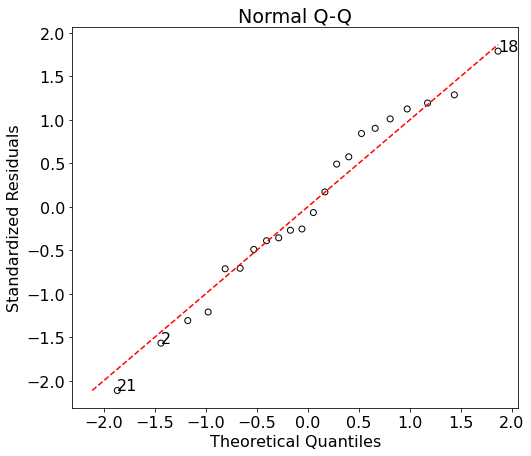

In [24]:
sorted_student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
sorted_student_residuals.index = results.resid.index
sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
df = pd.DataFrame(sorted_student_residuals)
df.columns = ['sorted_student_residuals']
df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)
top3 = rankings[:3]

fig, ax = plt.subplots()
x = df['theoretical_quantiles']
y = df['sorted_student_residuals']
ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
ax.set_title('Normal Q-Q')
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Theoretical Quantiles')
ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
for val in top3.index:
    ax.annotate(val,xy=(df['theoretical_quantiles'].loc[val],df['sorted_student_residuals'].loc[val]))
plt.show()

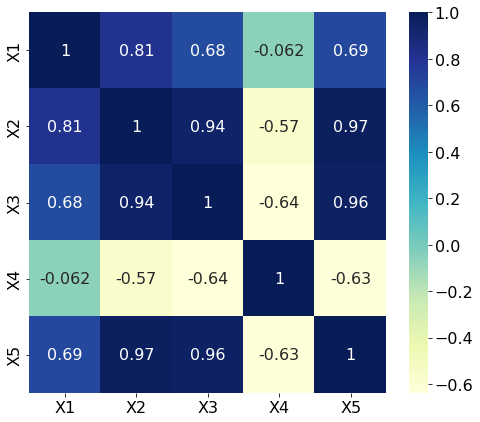

In [25]:
dataplot = sns.heatmap(df_data[["X1","X2", "X3", "X4", "X5"]].corr(), cmap="YlGnBu", annot=True)
plt.show()

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# the independent variables set
X = df_data[['X1', 'X2', 'X3', "X4", "X5"]]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

  feature          VIF
0      X1  1439.977869
1      X2    73.824181
2      X3   537.815384
3      X4   770.922697
4      X5   685.865594


In [27]:
import pandas as pd
from sklearn.datasets import load_boston
boston_data = load_boston()
df_boston = pd.DataFrame(data=boston_data.data, columns=boston_data.feature_names)
df_boston['target'] = pd.Series(boston_data.target)
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [28]:
X=df_boston[boston_data.feature_names]
y=df_boston['target']

In [29]:
def backward_regression(X, y,
                           initial_list=[], 
                           threshold_in=0.01, 
                           threshold_out = 0.05, 
                           verbose=True):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop  with p-value '.format(worst_feature, worst_pval))
        if not changed:
            break
    return included



In [30]:
backward_regression(X,y)

Drop  with p-value 
Drop  with p-value 


['CRIM',
 'ZN',
 'CHAS',
 'NOX',
 'RM',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 789 )

In [34]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
X = X_train
y = y_train
names=pd.DataFrame(X_train.columns)

In [35]:
from sklearn.linear_model import LinearRegression
#use linear regression as the model
lin_reg = LinearRegression()

#This is to select 5 variables: can be changed and checked in model for accuracy
rfe_mod = RFE(lin_reg, 5, step=1) #RFECV(lin_reg, step=1, cv=5) 
myvalues=rfe_mod.fit(X,y) #to fit
myvalues.support_#The mask of selected features.
myvalues.ranking_ #The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1.

rankings=pd.DataFrame(myvalues.ranking_) #Make it into data frame
rankings

array([False, False, False,  True,  True,  True, False,  True, False,
       False,  True, False, False])

array([4, 6, 5, 1, 1, 1, 9, 1, 3, 8, 1, 7, 2])

,0
0,4
1,6
2,5
3,1
4,1
5,1
6,9
7,1
8,3
9,8


In [36]:
#Concat and name columns
ranked=pd.concat([names,rankings], axis=1)
ranked.columns = ["Feature", "Rank"]
ranked

#Select most important (Only 1's)
most_important = ranked.loc[ranked['Rank'] ==1] 
print(most_important)

most_important['Rank'].count()

,Feature,Rank
0,CRIM,4
1,ZN,6
2,INDUS,5
3,CHAS,1
4,NOX,1
5,RM,1
6,AGE,9
7,DIS,1
8,RAD,3
9,TAX,8


    Feature  Rank
3      CHAS     1
4       NOX     1
5        RM     1
7       DIS     1
10  PTRATIO     1


5

In [64]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
model = SelectKBest(score_func=f_regression, k=4)
results = model.fit(X, y)

print (results.scores_)
#print (results.pvalues_)

results_df=pd.DataFrame(results.scores_)
#Concat and name columns
scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Score"]
scored.sort_values(by=['Score']).head(13)

[ 78.25607999  56.78015283 114.22727097  10.07688737  84.25065294
 405.28129253  65.03590424  26.01777451  65.8252604  108.42873488
 147.81378411  53.05830015 495.78300559]


,Feature,Score
3,CHAS,10.076887
7,DIS,26.017775
11,B,53.058300
1,ZN,56.780153
6,AGE,65.035904
8,RAD,65.825260
0,CRIM,78.256080
4,NOX,84.250653
9,TAX,108.428735
2,INDUS,114.227271


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


<Figure size 864x720 with 0 Axes>

<bound method XAxis.tick_top of <matplotlib.axis.XAxis object at 0x000001A2CB040FA0>>

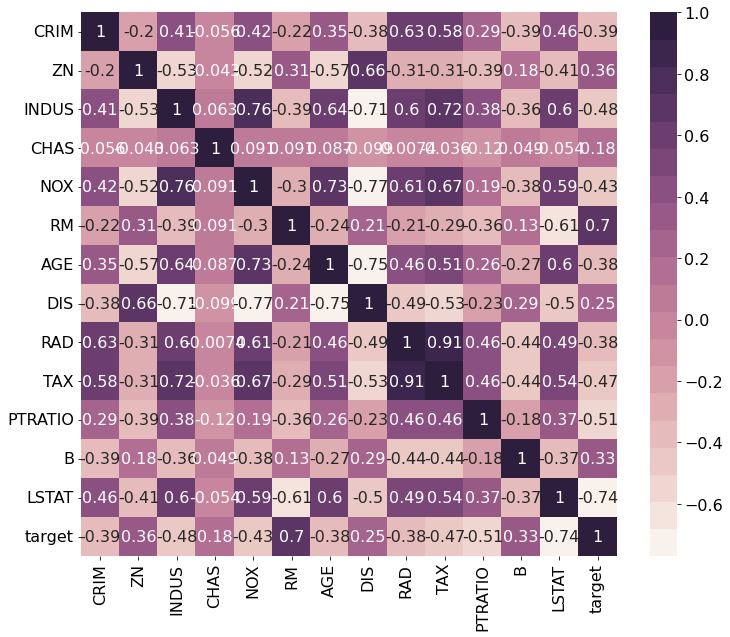

In [41]:
#create a single data frame with both features and target by concatonating
boston_df=pd.concat([df_boston[boston_data.feature_names], df_boston['target']], axis=1)
boston_df.head()

#Visualize corelations
import seaborn as sns
plt.figure(figsize=(12,10))
ax=sns.heatmap(boston_df.corr(), annot=True, cmap=sns.cubehelix_palette(20,  light=0.95, dark=0.15))
ax.xaxis.tick_top
plt.show()